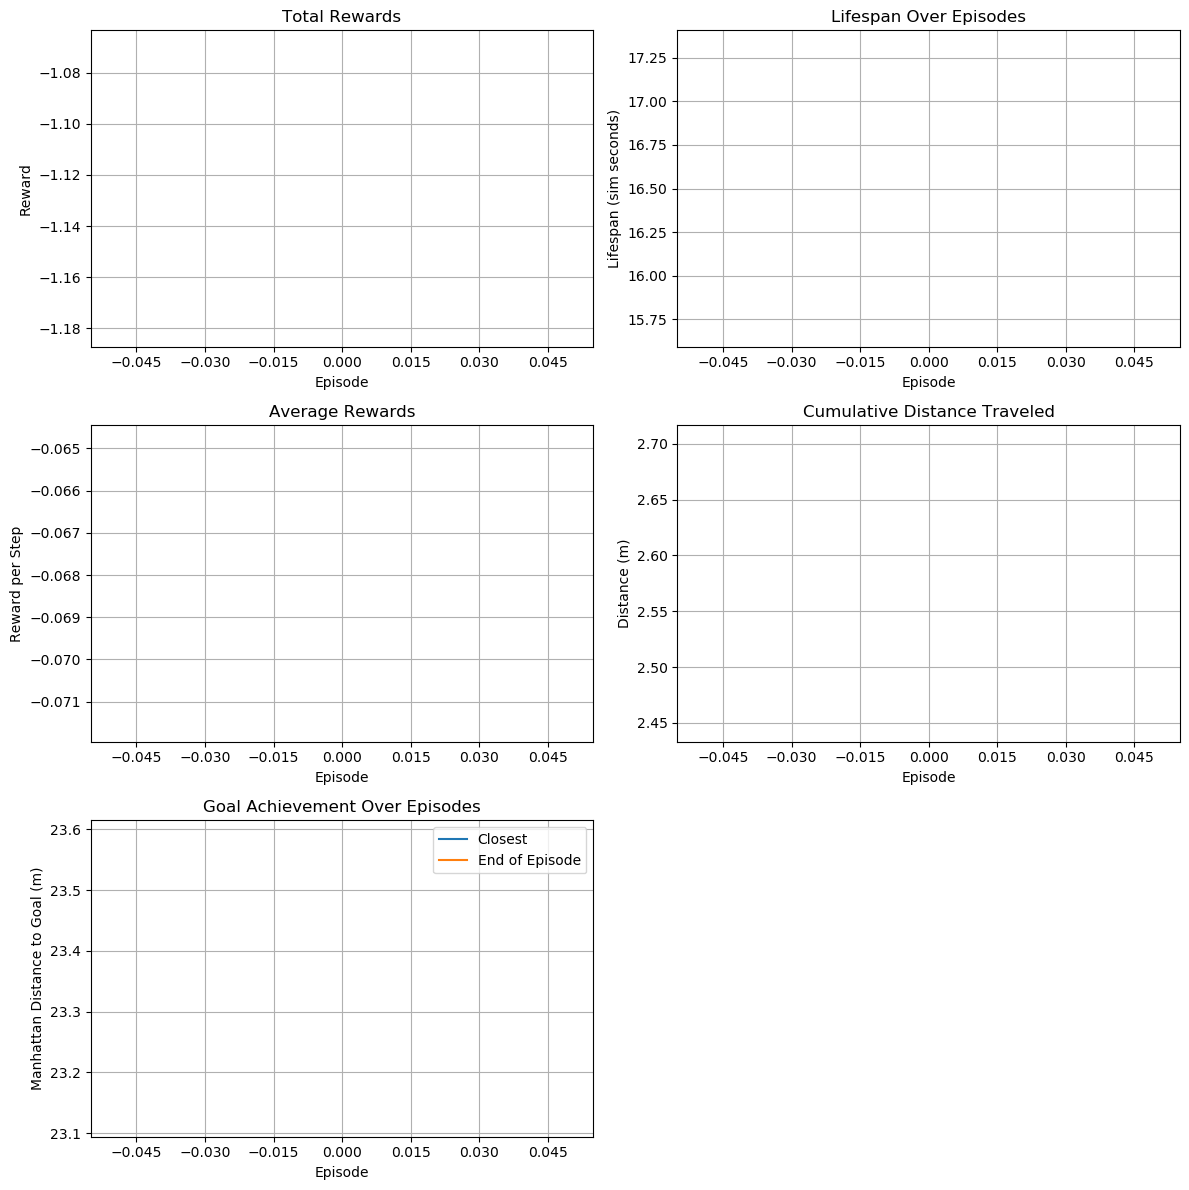

Text(0, 0.5, 'MSE Loss')

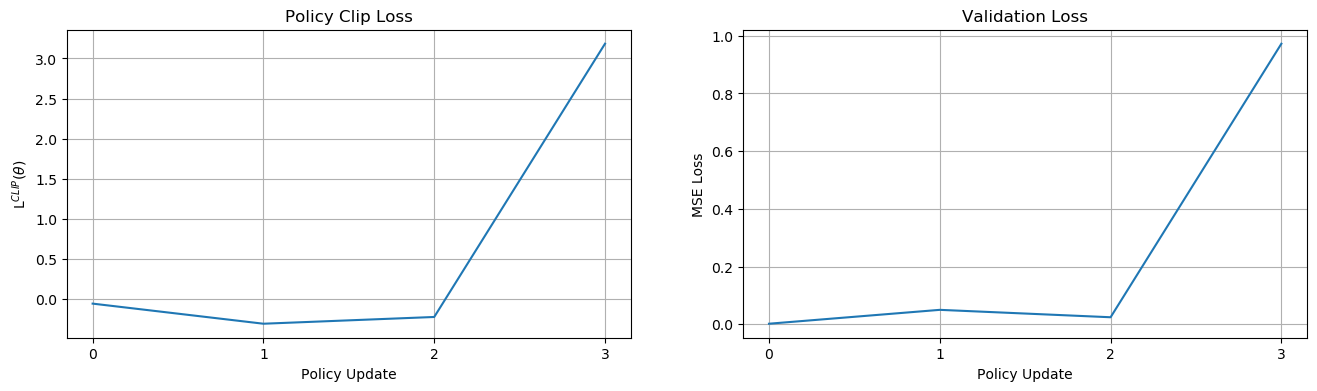

In [44]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import os

# Sorting function to ensure files are processed in numerical order
def sort_key(filename):
    parts = filename.split('_')
    number_part = parts[1].split('.')[0]  # Get the part of the filename that is the number
    return int(number_part)

def get_logs(run_path, folder_name):
    directory_path = os.path.join(run_path, folder_name)
    # List to hold all the values
    values = []

    # Loop through each file in the directory
    for filename in sorted(os.listdir(directory_path), key=sort_key):
        if filename.endswith('.txt'):
            # Construct the full file path
            file_path = os.path.join(directory_path, filename)
            # Open and read the file
            with open(file_path, 'r') as file:
                for line in file:
                    # Append the line to the values list
                    values.append(line.strip())  # No need to convert to float for goal data

    return values


# Path to the directory containing the files
run = '/media/ryan/DataPad/ros_ws/src/notspot_sim_py/src/reinforcement_learning/runs/2024_04_22_18_22_00'

rewards = [float(reward) for reward in get_logs(run, "rewards")]
lifespans = [int(lifespan)*0.75 for lifespan in get_logs(run, "steps")]
closest_goal = [float(dist) for i, dist in enumerate(get_logs(run, "goal")) if i%2 == 0]
ending_goal = [float(dist) for i, dist in enumerate(get_logs(run, "goal")) if i%2 == 1]
distance = [float(dist) for dist in get_logs(run, "distance")]
rewards_per_step = [reward / lifespan if lifespan > 0 else reward for reward, lifespan in zip(rewards, lifespans)]

policy_loss = [float(loss) for loss in get_logs(run+'/models/loss', "policy")]
value_loss = [float(loss) for loss in get_logs(run+'/models/loss', "value")]


# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

for ax in axs.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.grid(True)


# Plot total rewards over episodes
axs[0, 0].plot(rewards)
axs[0, 0].set_title('Total Rewards')
axs[0, 0].set_xlabel('Episode')
axs[0, 0].set_ylabel('Reward')
# axs[0, 0].legend()

# Plot average rewards per step over episodes
axs[1, 0].plot( rewards_per_step)
axs[1, 0].set_title('Average Rewards')
axs[1, 0].set_xlabel('Episode')
axs[1, 0].set_ylabel('Reward per Step')
# axs[0, 1].legend()

# Plot lifespan over episodes
axs[0, 1].plot(lifespans)
axs[0, 1].set_xlabel('Episode')
axs[0, 1].set_ylabel('Lifespan (sim seconds)')
axs[0, 1].set_title('Lifespan Over Episodes')
# axs[1, 0].legend()

# Plot goal achievement over episodes
axs[2, 0].plot(closest_goal, label='Closest')
axs[2, 0].plot(ending_goal, label='End of Episode')
axs[2, 0].set_xlabel('Episode')
axs[2, 0].set_ylabel('Manhattan Distance to Goal (m)')
axs[2, 0].set_title('Goal Achievement Over Episodes')
axs[2, 0].legend()

# Plot cumulative distance traveled over episodes
axs[1, 1].plot(distance, label='Distance')
axs[1, 1].set_title('Cumulative Distance Traveled')
axs[1, 1].set_xlabel('Episode')
axs[1, 1].set_ylabel('Distance (m)')
# axs[1, 1].legend()

# Hide the empty subplot
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

for ax in axs.flatten():
    ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax.grid(True)


# Plot total rewards over episodes
axs[0].plot(policy_loss)
axs[0].set_title('Policy Clip Loss')
axs[0].set_xlabel('Policy Update')
axs[0].set_ylabel(r'L$^{CLIP}$($\theta$)')
# axs[0].legend()

# Plot average rewards per step over episodes
axs[1].plot(value_loss)
axs[1].set_title('Validation Loss')
axs[1].set_xlabel('Policy Update')
axs[1].set_ylabel('MSE Loss')
# axs[1].legend()
